C:\Users\manan\AppData\Local\Temp\ipykernel_11356\2120995015.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weights_df = pd.concat([


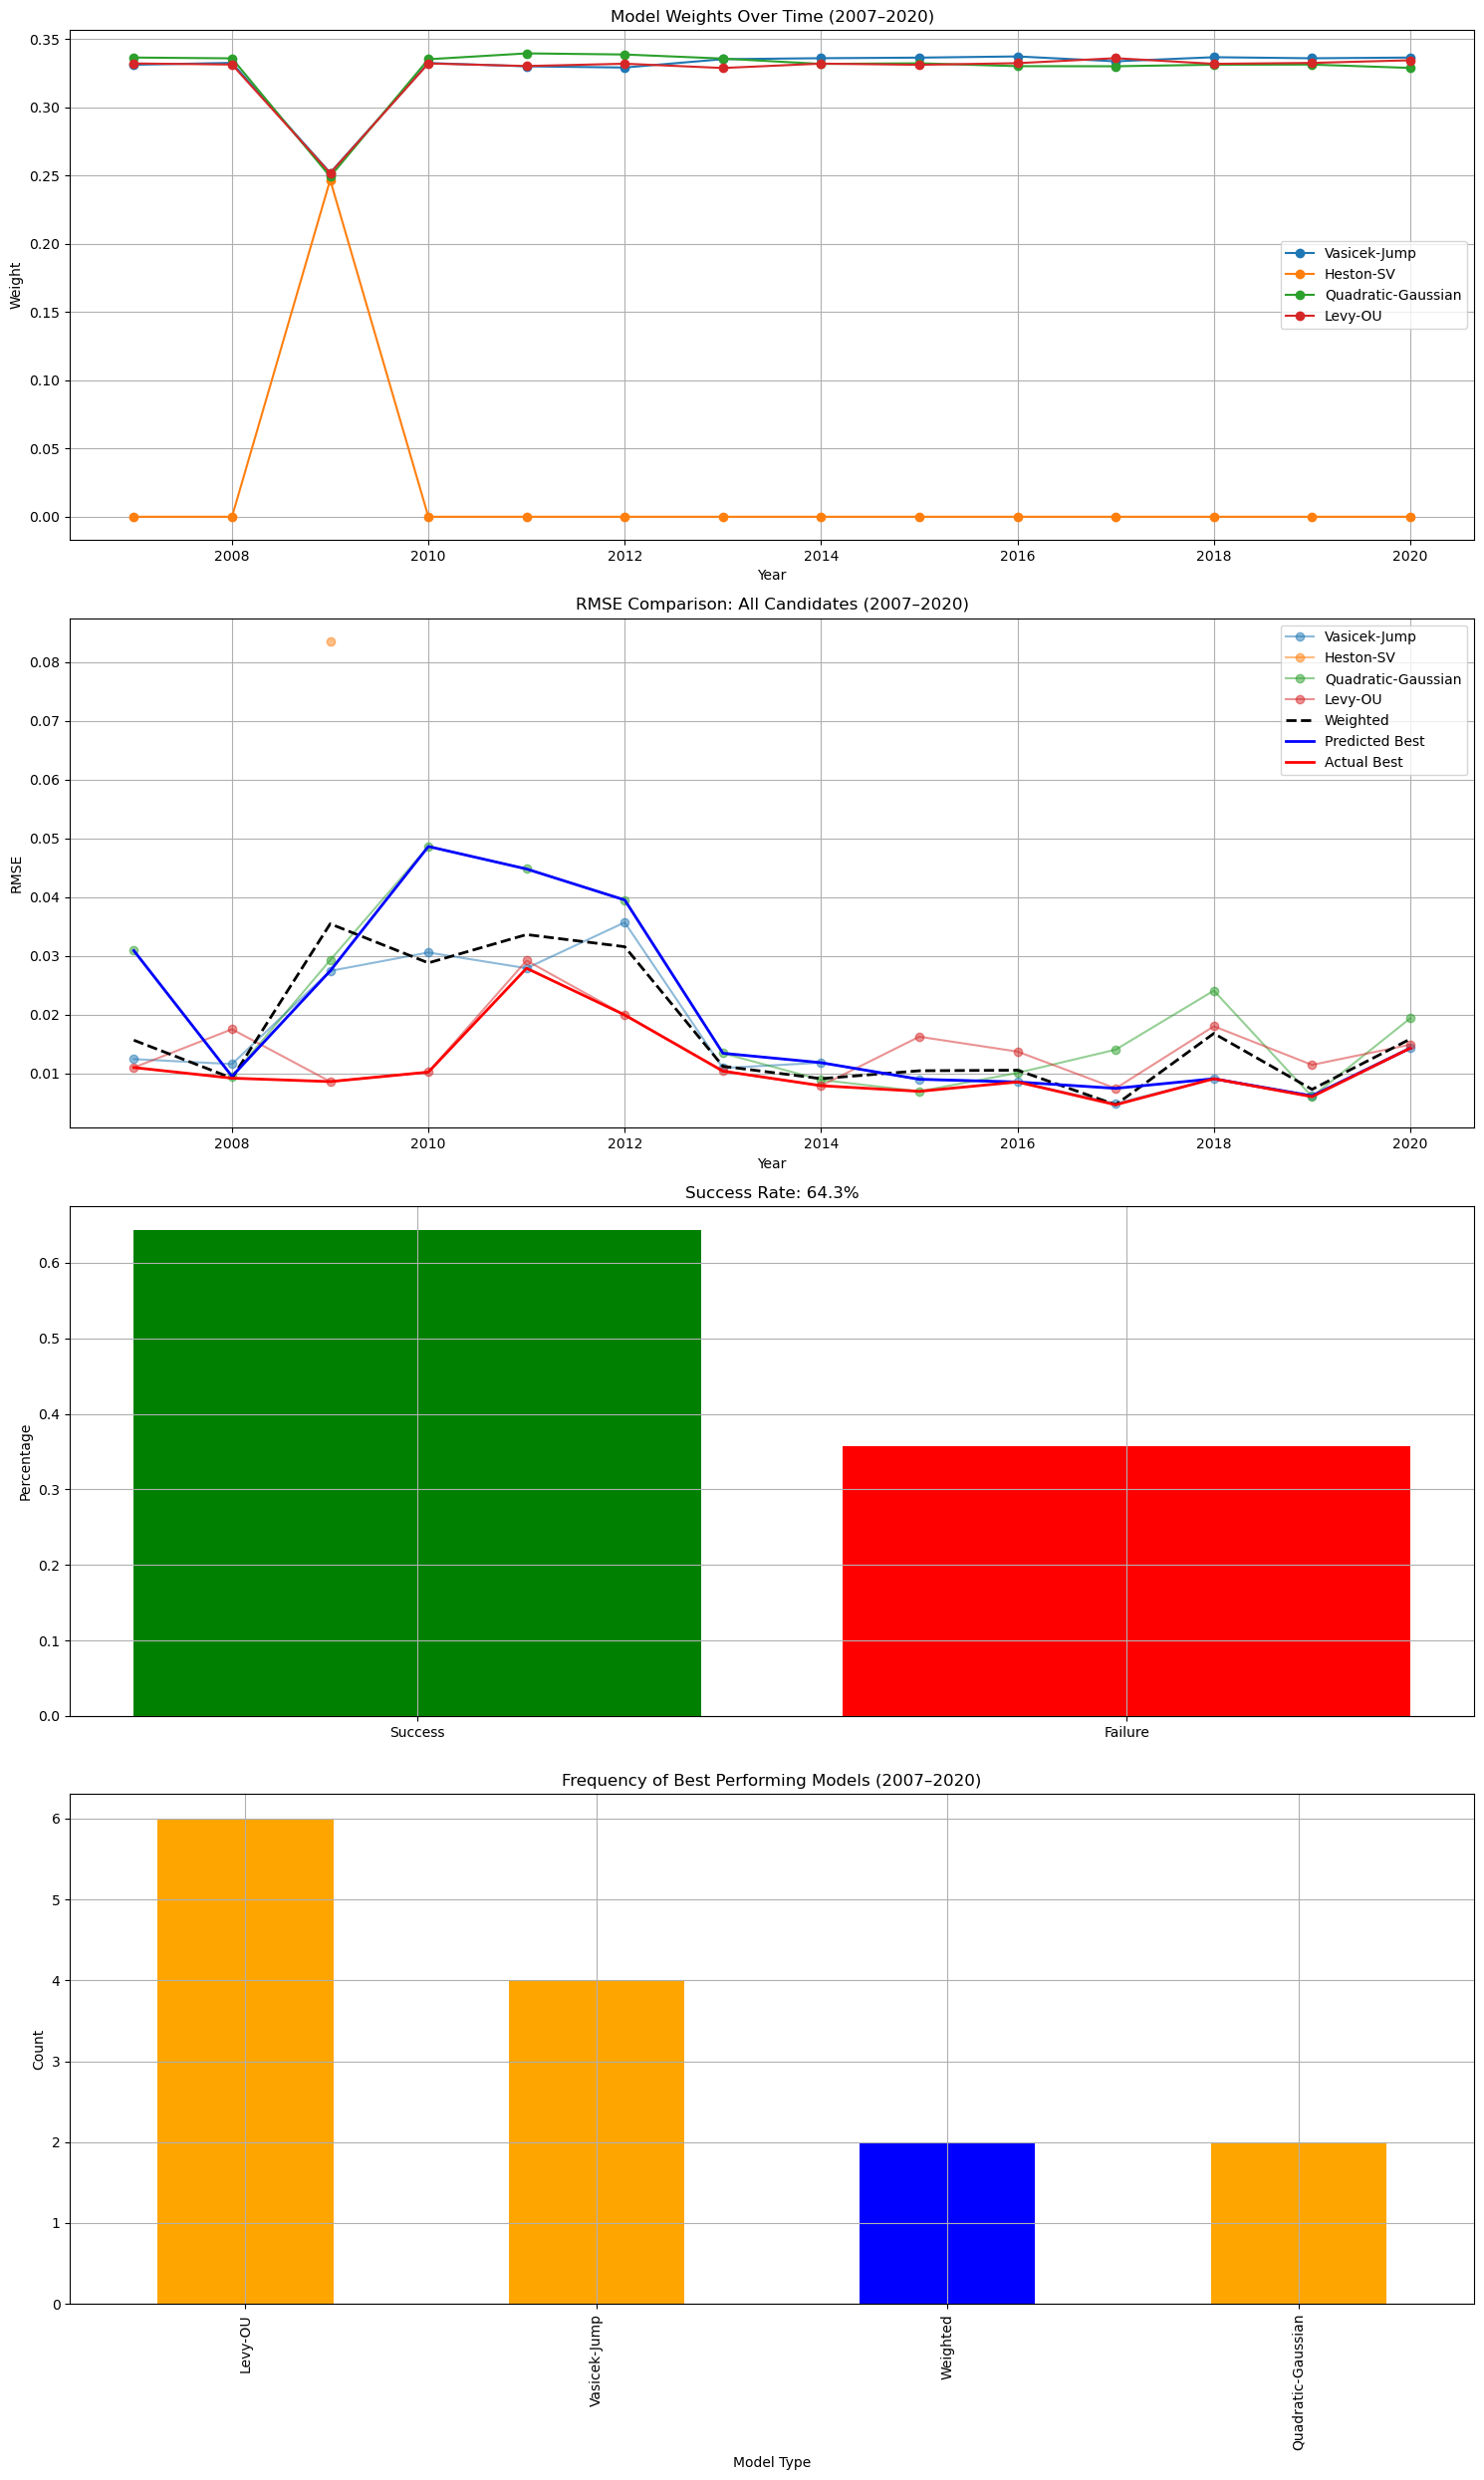


Model Weights by Year:
Year  Vasicek-Jump  Heston-SV  Quadratic-Gaussian  Levy-OU
2007      0.331253   0.000000            0.336535 0.332212
2008      0.332637   0.000000            0.335958 0.331406
2009      0.252041   0.246871            0.249303 0.251785
2010      0.332514   0.000000            0.335285 0.332201
2011      0.330098   0.000000            0.339586 0.330317
2012      0.329221   0.000000            0.338766 0.332013
2013      0.335335   0.000000            0.335781 0.328884
2014      0.336061   0.000000            0.331862 0.332077
2015      0.336471   0.000000            0.332327 0.331202
2016      0.337356   0.000000            0.330226 0.332418
2017      0.333777   0.000000            0.330152 0.336071
2018      0.336785   0.000000            0.331285 0.331929
2019      0.336012   0.000000            0.331375 0.332613
2020      0.336532   0.000000            0.328935 0.334532

Model Performance Summary:
 Year  Vasicek-Jump  Heston-SV  Quadratic-Gaussian  Levy-OU  We

In [7]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import seaborn as sns

np.random.seed(42)

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2025, 1, 1)
data = web.DataReader('DGS1', 'fred', start, end).dropna()
r = data['DGS1'].values / 100
dates = data.index
dt = 1 / 252

def vasicek_jump_model(x, theta):
    a, b, sigma, jump_lambda, jump_mu, jump_sigma = theta
    r = np.zeros_like(x, dtype=np.float64)
    r[0] = b
    for t in range(1, len(x)):
        jump = np.random.poisson(jump_lambda * dt) * (jump_mu + jump_sigma * np.random.normal())
        r[t] = r[t - 1] + a * (b - r[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal() + jump
    return r

def heston_short_rate_model(x, theta):
    a, b, sigma_v, rho, v0 = theta
    r = np.zeros_like(x, dtype=np.float64)
    v = np.zeros_like(x, dtype=np.float64)
    r[0] = b
    v[0] = v0
    for t in range(1, len(x)):
        dw1 = np.random.normal()
        dw2 = rho * dw1 + np.sqrt(1 - rho**2) * np.random.normal()
        v[t] = np.abs(v[t - 1] + a * (b - v[t - 1]) * dt + sigma_v * np.sqrt(v[t - 1]) * np.sqrt(dt) * dw1)
        r[t] = r[t - 1] + np.sqrt(v[t]) * np.sqrt(dt) * dw2
    return r

def quadratic_gaussian_model(x, theta):
    a, b, c, sigma = theta
    r = np.zeros_like(x, dtype=np.float64)
    r[0] = c
    for t in range(1, len(x)):
        theta_t = a * (t * dt)**2 + b * (t * dt) + c
        r[t] = r[t - 1] + (theta_t - r[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    return r

def levy_mean_reverting_model(x, theta):
    a, b, sigma, alpha = theta
    r = np.zeros_like(x, dtype=np.float64)
    r[0] = b
    for t in range(1, len(x)):
        noise = np.random.standard_cauchy() if alpha < 1.5 else np.random.normal()
        r[t] = r[t - 1] + a * (b - r[t - 1]) * dt + sigma * (dt**(1 / alpha)) * noise
    return r

models = {
    1: {"name": "Vasicek-Jump", "func": vasicek_jump_model, "dim": 6,
        "prior": [(0.1, 3.0), (0.01, 0.10), (0.005, 0.03), (0.0, 0.5), (-0.02, 0.02), (0.005, 0.03)]},
    2: {"name": "Heston-SV", "func": heston_short_rate_model, "dim": 5,
        "prior": [(0.1, 3.0), (0.01, 0.10), (0.01, 0.3), (-0.9, 0.9), (0.01, 0.1)]},
    3: {"name": "Quadratic-Gaussian", "func": quadratic_gaussian_model, "dim": 4,
        "prior": [(-0.001, 0.001), (-0.1, 0.1), (0.01, 0.05), (0.005, 0.03)]},
    4: {"name": "Levy-OU", "func": levy_mean_reverting_model, "dim": 4,
        "prior": [(0.1, 3.0), (0.01, 0.10), (0.01, 0.10), (1.1, 2.0)]}
}

def calibrate_epsilon(train_data, models, n_samples=1000):
    test_epsilons = np.linspace(0.01, 0.5, 50)
    acceptance_rates = []
    for epsilon in test_epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            sim_data = model["func"](np.zeros_like(train_data), theta)
            dist = np.sqrt(mean_squared_error(train_data, sim_data))
            if dist < epsilon:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)
    optimal_idx = np.argmin(np.abs(np.array(acceptance_rates) - 0.025))
    return test_epsilons[optimal_idx]

def abc_rjmcmc_adaptive(obs, models, epsilon, n_iter=4000):
    model_performance = {k: {"rmse": [], "params": []} for k in models}
    proposals = {}
    for m in models:
        dim = models[m]["dim"]
        proposals[m] = {
            'mean': np.array([np.mean(bounds) for bounds in models[m]["prior"]]),
            'cov': np.diag([(bounds[1]-bounds[0])**2/12 for bounds in models[m]["prior"]])
        }
    for i in range(n_iter):
        model_id = np.random.choice(list(models.keys()))
        model = models[model_id]
        if len(model_performance[model_id]["params"]) > 50:
            samples = np.array(model_performance[model_id]["params"])
            prop_mean = np.mean(samples, axis=0)
            prop_cov = np.cov(samples.T) + 1e-6*np.eye(model["dim"])
            theta = multivariate_normal.rvs(mean=prop_mean, cov=prop_cov)
            theta = np.clip(theta, [b[0] for b in model["prior"]], [b[1] for b in model["prior"]])
        else:
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        sim_data = model["func"](np.zeros_like(obs), theta)
        dist = np.sqrt(mean_squared_error(obs, sim_data))
        if dist < epsilon:
            model_performance[model_id]["rmse"].append(dist)
            model_performance[model_id]["params"].append(theta)
    return model_performance

def calculate_model_weights(performance_dict, temperature=0.1):
    avg_rmses = {}
    for model_id, perf in performance_dict.items():
        if perf["rmse"]:
            avg_rmses[model_id] = np.exp(-np.mean(perf["rmse"]) / temperature)
        else:
            avg_rmses[model_id] = 0
    total = sum(avg_rmses.values())
    return {model_id: (val / total if total > 0 else 1 / len(avg_rmses)) for model_id, val in avg_rmses.items()}

years = range(2006, 2024)
calibration_period = (dates >= datetime.datetime(2000, 1, 1)) & (dates < datetime.datetime(2005, 1, 1))
calibration_data = r[calibration_period]
fixed_epsilon = calibrate_epsilon(calibration_data, models)

results = []
model_names = [model["name"] for model in models.values()]
weights_df = pd.DataFrame(columns=["Year"] + model_names)

for year in years:
    train_start = year - 5
    train_mask = (dates >= datetime.datetime(train_start, 1, 1)) & (dates < datetime.datetime(year, 1, 1))
    test_mask = (dates >= datetime.datetime(year, 1, 1)) & (dates < datetime.datetime(year + 1, 1, 1))
    train_data = r[train_mask]
    test_data = r[test_mask]
    model_performance = abc_rjmcmc_adaptive(train_data, models, fixed_epsilon)
    model_weights = calculate_model_weights(model_performance)
    weight_dict = {models[model_id]["name"]: weight for model_id, weight in model_weights.items()}
    weights_df = pd.concat([
        weights_df,
        pd.DataFrame({"Year": [year], **{model: [weight_dict.get(model, 0)] for model in model_names}})
    ], ignore_index=True)
    model_rmse = {}
    weighted_pred = np.zeros_like(test_data)
    predicted_best_model = max(weight_dict, key=weight_dict.get)
    for model_id, perf in model_performance.items():
        model_name = models[model_id]["name"]
        if not perf["params"]:
            model_rmse[model_name] = np.nan
            continue
        best_idx = np.argmin(perf["rmse"])
        best_theta = perf["params"][best_idx]
        pred = models[model_id]["func"](np.zeros_like(test_data), best_theta)
        rmse = np.sqrt(mean_squared_error(test_data, pred))
        model_rmse[model_name] = rmse
        weighted_pred += weight_dict.get(model_name, 0) * pred
    weighted_rmse = np.sqrt(mean_squared_error(test_data, weighted_pred))
    candidate_models = {
        **model_rmse,
        "Weighted": weighted_rmse,
        predicted_best_model: model_rmse.get(predicted_best_model, np.nan)
    }
    actual_best_model = min(candidate_models, key=lambda k: candidate_models[k] if not np.isnan(candidate_models[k]) else np.inf)
    actual_best_rmse = candidate_models[actual_best_model]
    success_cases = [
        predicted_best_model == actual_best_model,
        actual_best_model == "Weighted",
        abs(model_rmse.get(predicted_best_model, np.inf) - actual_best_rmse) < 0.005,
        weighted_rmse < min([v for v in model_rmse.values() if not np.isnan(v)]) * 1.05
    ]
    is_success = any(success_cases)
    results.append({
        "Year": year,
        **{model: model_rmse.get(model, np.nan) for model in model_names},
        "Weighted RMSE": weighted_rmse,
        "Predicted Best Model": predicted_best_model,
        "Predicted Best RMSE": model_rmse.get(predicted_best_model, np.nan),
        "Actual Best Model": actual_best_model,
        "Actual Best RMSE": actual_best_rmse,
        "Success": is_success
    })

df_results = pd.DataFrame(results)
df_results_filtered = df_results[(df_results["Year"] >= 2007) & (df_results["Year"] <= 2020)]
weights_df_filtered = weights_df[(weights_df["Year"] >= 2007) & (weights_df["Year"] <= 2020)]

plt.figure(figsize=(15, 25))

plt.subplot(4, 1, 1)
for model in model_names:
    plt.plot(weights_df_filtered["Year"], weights_df_filtered[model], 'o-', label=model)
plt.title("Model Weights Over Time (2007–2020)")
plt.xlabel("Year")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
for model in model_names:
    plt.plot(df_results_filtered["Year"], df_results_filtered[model], 'o-', label=model, alpha=0.5)
plt.plot(df_results_filtered["Year"], df_results_filtered["Weighted RMSE"], 'k--', label='Weighted', linewidth=2)
plt.plot(df_results_filtered["Year"], df_results_filtered["Predicted Best RMSE"], 'b-', label='Predicted Best', linewidth=2)
plt.plot(df_results_filtered["Year"], df_results_filtered["Actual Best RMSE"], 'r-', label='Actual Best', linewidth=2)
plt.title("RMSE Comparison: All Candidates (2007–2020)")
plt.xlabel("Year")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
success_rate = df_results_filtered["Success"].mean()
plt.bar(["Success", "Failure"], [success_rate, 1 - success_rate], color=['green', 'red'])
plt.title(f"Success Rate: {success_rate:.1%}")
plt.ylabel("Percentage")
plt.grid(True)

plt.subplot(4, 1, 4)
best_model_counts = df_results_filtered["Actual Best Model"].value_counts()
colors = ['blue' if x == 'Weighted' else 'orange' for x in best_model_counts.index]
best_model_counts.plot(kind='bar', color=colors)
plt.title("Frequency of Best Performing Models (2007–2020)")
plt.xlabel("Model Type")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nModel Weights by Year:")
print(weights_df_filtered.to_string(index=False))

print("\nModel Performance Summary:")
print(df_results_filtered[[
    "Year", *model_names, "Weighted RMSE", 
    "Predicted Best Model", "Predicted Best RMSE",
    "Actual Best Model", "Actual Best RMSE", "Success"
]].to_string(index=False))

weighted_best_rate = (df_results_filtered["Actual Best Model"] == "Weighted").mean()
predicted_correct_rate = (df_results_filtered["Predicted Best Model"] == df_results_filtered["Actual Best Model"]).mean()
near_best_rate = np.mean([
    abs(row["Predicted Best RMSE"] - row["Actual Best RMSE"]) < 0.005
    for _, row in df_results_filtered.iterrows()
])
weighted_close_rate = np.mean([
    row["Weighted RMSE"] < min([row[m] for m in model_names if not pd.isna(row[m])]) * 1.05
    for _, row in df_results_filtered.iterrows()
])

print(f"\nSuccess Metrics:")
print(f"- Overall Success Rate: {success_rate:.1%}")
print(f"- Weighted Model as Best Performer: {weighted_best_rate:.1%} of years")
print(f"- Predicted Best Model Correct: {predicted_correct_rate:.1%} of years")
print(f"- Predicted Within 0.005 of Best RMSE: {near_best_rate:.1%} of years")
print(f"- Weighted RMSE Within 5% of Best: {weighted_close_rate:.1%} of years")
